# Explore Satellogic EarthView dataset 🛰 🌍

This notebook shows how to easily explore Satellogic EarthView dataset available in AWS Open Data Registry.

## Items 🗺

In order to navigate throught the 7 million items, we provide a parquet file containing a geodataframe with their path within the bucket, geometry, zone, region and date.

## Dependencies

To run this notebook, you'll need to install the following libraries:
- Pyarrow
- Geopandas
- Folium
- Rasterio
- Pyproj

In [1]:
!pip install geopandas pyarrow folium rasterio pyproj

# Download parquet file

In [2]:
!curl -O https://satellogic-earthview.s3.us-west-2.amazonaws.com/colab/satellogic-earthview-items.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  258M  100  258M    0     0  27.6M      0  0:00:09  0:00:09 --:--:-- 23.1M


# Explore the geodataframe

In [3]:
import geopandas as gpd
gdf = gpd.read_parquet('satellogic-earthview-items.parquet')

In [4]:
# see what's inside
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7095985 entries, 0 to 7095984
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   json_path  object        
 1   zone       object        
 2   region     object        
 3   date       datetime64[ns]
 4   geometry   geometry      
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 324.8+ MB


In [5]:
# let's look at the first elements
gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


# Let's visualize an item geometry over the map

In [6]:
import folium

index = 400
# we will only visualize the first one
geometry = gdf.iloc[index]
# map center and zoom
centroid = geometry.geometry.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)
# adding the geomtry of the item to the map
folium.GeoJson(gdf.iloc[index]['geometry']).add_to(m)
# display the map
m

# Let's find out what items intersect with California

In [7]:
!curl -O https://satellogic-earthview.s3.us-west-2.amazonaws.com/colab/california.geojson

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7267  100  7267    0     0  17425      0 --:--:-- --:--:-- --:--:-- 17468


In [8]:
gdf_california = gpd.read_file('california.geojson')

In [9]:
gdf.intersects(gdf_california.iloc[0]['geometry']).any()

True

In [10]:
gdf_intersection = gdf[gdf.intersects(gdf_california.iloc[0]['geometry'])]

In [11]:
# visualize one of these items that intersect California
index = 1000
geometry = gdf_intersection.iloc[index]
# map center and zoom
centroid = geometry.geometry.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=13)
# adding the geomtry of the item to the map
folium.GeoJson(gdf_intersection.iloc[index]['geometry']).add_to(m)
# display the map
m

# Let's download the geotiff and visualize it

In [12]:
gdf_intersection.iloc[index]

,37054
json_path,data/json/zone=10N/region=481264_4349036/date=...
zone,10N
region,481264_4349036
date,2022-08-20 00:00:00
geometry,"POLYGON ((-123.212799414202 39.287039218833, -..."


In [13]:
import os
visual_path = gdf_intersection.iloc[index]['json_path'].replace('/json/', '/tif/').replace('_metadata.json', '_VISUAL.tif')
visual_url = os.path.join('https://satellogic-earthview.s3.us-west-2.amazonaws.com/', visual_path)
os.system(f"curl -O {visual_url}")

0


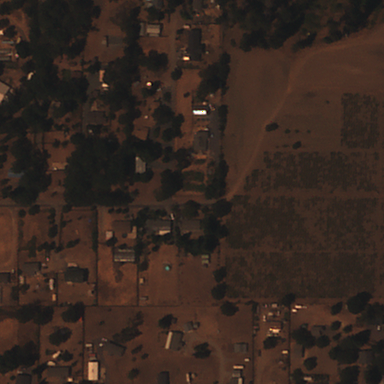

In [14]:
import folium
import rasterio as rio
from folium import raster_layers
import pyproj
from rasterio.warp import transform

visual_path = os.path.basename(visual_url)

# Open the GeoTIFF with rasterio
with rio.open(visual_path) as src:

    min_lon, min_lat, max_lon, max_lat = src.bounds
    current_crs = src.crs

    # to visualize it we need to reproject it to epsg:4326
    target_crs = pyproj.CRS('EPSG:4326')

    # transformer
    transformer = pyproj.Transformer.from_crs(current_crs, target_crs, always_xy=True)

    # transform them and get the center
    min_lon_4326, min_lat_4326 = transformer.transform(min_lon, min_lat)
    max_lon_4326, max_lat_4326 = transformer.transform(max_lon, max_lat)
    center_lat = (min_lat_4326 + max_lat_4326) / 2
    center_lon = (min_lon_4326 + max_lon_4326) / 2

    # create the map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=16)

    # read the image and transpose it
    img_array = src.read().transpose(1,2,0)

    # add the raster to it
    raster_layers.ImageOverlay(
        image=img_array,
        bounds=[[min_lat_4326, min_lon_4326], [max_lat_4326, max_lon_4326]],
        opacity=1.0,
        interactive=True
    ).add_to(m)

# Show the raster
m


# Let's download the analytic geotiff and compute the NDVI

In [15]:
import os
toa_path = gdf_intersection.iloc[index]['json_path'].replace('/json/', '/tif/').replace('_metadata.json', '_TOA.tif')
toa_url = os.path.join('https://satellogic-earthview.s3.us-west-2.amazonaws.com/', toa_path)
os.system(f"curl -O {toa_url}")

0


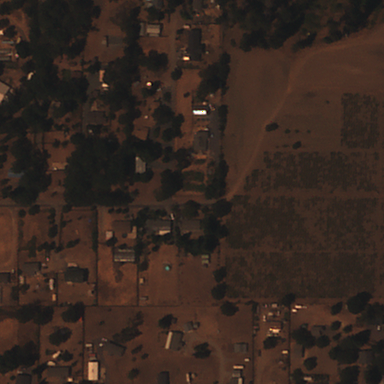
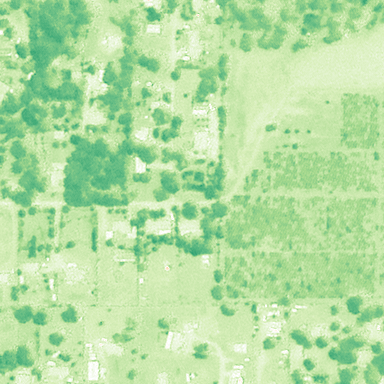

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np


with rio.open(toa_url) as src:
    red_band = src.read(1).astype('float32') / 10000
    nir_band = src.read(4).astype('float32') / 10000
    with np.errstate(divide='ignore', invalid='ignore'):  # handle division
        ndvi = (nir_band - red_band) / (nir_band + red_band)

    ndvi[np.isnan(ndvi)] = 0
    normed_ndvi = ((ndvi + 1) / 2) # from (-1,1) to (0, 1) for the cmap

    cmap = plt.cm.RdYlGn
    rgba_image = cmap(normed_ndvi)

    rgba_image = (rgba_image[:, :, :3] * 255).astype(np.uint8)
    # Let's reuse the coords of the VISUAL geotiff
    raster_layers.ImageOverlay(
        image=rgba_image,
        bounds=[[min_lat_4326, min_lon_4326], [max_lat_4326, max_lon_4326]]
    ).add_to(m)


# show the map
m

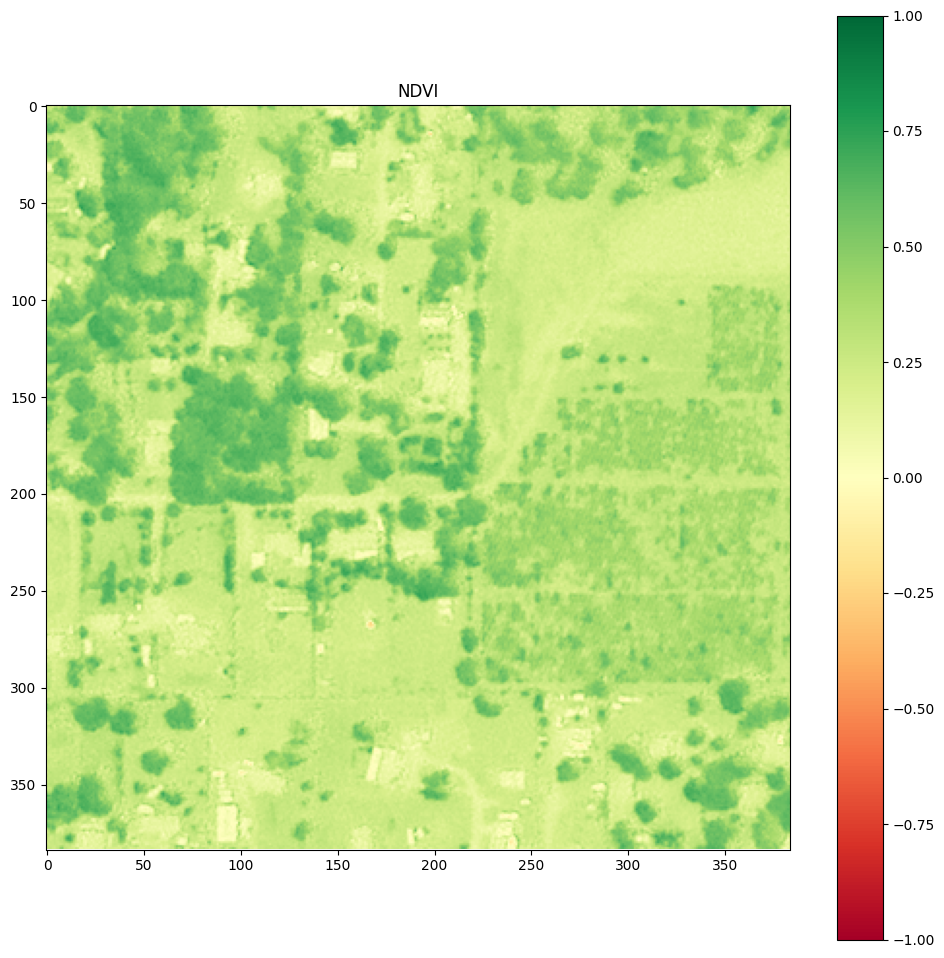

In [17]:
# visualize the colorbar together
plt.figure(figsize=(12,12))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI')
plt.show()